In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import optimize, signal, integrate, stats

from sklearn import metrics
from sklearn.linear_model import LinearRegression

## Inputs

In [2]:
T0 = 292.05           # K
p0 = 101600           # Pa
m = 2.7677            # g of Catalyst

In [3]:
R = 8.31446261815324  # J/mol.K
V = 190e-3            # L of Isopropanol
rho = 785             # g/L
M = 60.1              # g/mol
n0 = rho/M*V          # mol

In [4]:
sigma = 15            # s

In [5]:
data = pd.read_csv("data/cathet.csv")

In [6]:
n0

2.4816971713810316

## Dataset

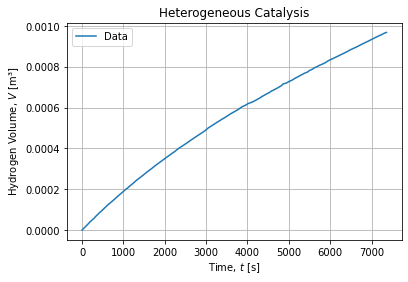

In [7]:
fig, axe = plt.subplots()
axe.plot(data["t"], data["V"], label="Data")
axe.set_title("Heterogeneous Catalysis")
axe.set_xlabel(r"Time, $t$ [s]")
axe.set_ylabel(r"Hydrogen Volume, $V$ [m³]")
axe.legend()
axe.grid()

## Model

In [8]:
def model(x, k1, k2):
    return (1/k1) * ((1 - k2)*x - k2*n0*np.log((n0 - x)/n0)) 

In [9]:
data["xi"] = p0*data["V"]/(R*T0)
data["st"] = sigma

In [10]:
popt, pcov = optimize.curve_fit(
    model, data["xi"].values, data["t"].values,
    sigma=data["st"].values, absolute_sigma=True
)

In [11]:
sk = np.sqrt(np.diag(pcov))

In [12]:
popt, sk

(array([9.03185361e-06, 7.80055898e+01]),
 array([2.09424662e-08, 5.39785853e-01]))

In [13]:
data["that"] = model(data["xi"].values, *popt)

In [14]:
R2 = metrics.r2_score(data["t"], data["that"])
R2

0.9999526276968933

In [15]:
nlls_integrated = {"k1": popt[0], "k2": popt[1], "R2": R2, "name": "NLLS Integrated"}

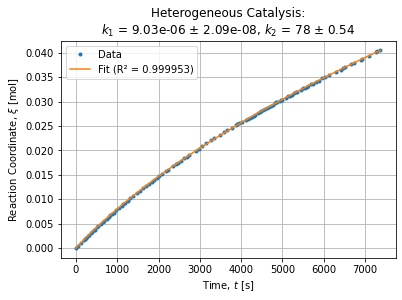

In [16]:
fig, axe = plt.subplots()
axe.plot(data["t"], data["xi"], label="Data", linestyle="none", marker=".")
axe.plot(data["that"], data["xi"], label="Fit (R² = {:.6f})".format(R2))
axe.set_title("Heterogeneous Catalysis:\n$k_1$ = {0:.3g} $\pm$ {2:.3g}, $k_2$ = {1:.3g} $\pm$ {3:.3g}".format(*popt, *sk))
axe.set_xlabel(r"Time, $t$ [s]")
axe.set_ylabel(r"Reaction Coordinate, $\xi$ [mol]")
axe.legend()
axe.grid()

## Loss & Optimality

In [17]:
def factory(t, xi):
    @np.vectorize
    def wrapped(k1, k2):
        return np.log10(0.5*np.sum(np.power(t - model(xi, k1, k2), 2)))
    return wrapped

In [18]:
loss = factory(data["t"].values, data["xi"].values)

In [19]:
res = 400
k1lin = np.linspace(8.5e-6, 9.5e-6, res)
k2lin = np.linspace(70, 85, res)
K1, K2 = np.meshgrid(k1lin, k2lin)

In [20]:
MLE = loss(K1, K2)

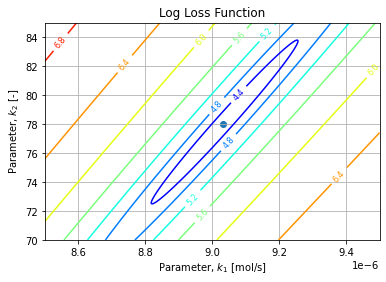

In [21]:
fig, axe = plt.subplots()
contour = axe.contour(K1, K2, MLE, cmap="jet")
axe.clabel(contour, contour.levels, inline=True, fontsize=8)
axe.scatter(*popt)
axe.set_title("Log Loss Function")
axe.set_xlabel("Parameter, $k_1$ [mol/s]")
axe.set_ylabel("Parameter, $k_2$ [-]")
#axe.set_xscale("log")
#axe.set_yscale("log")
axe.grid()

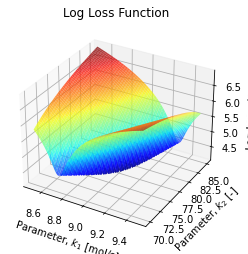

In [78]:
fig, axe = plt.subplots(subplot_kw={'projection': '3d'})
axe.plot_surface(K1, K2, MLE, cmap="jet", alpha=0.75)
axe.set_title("Log Loss Function")
axe.set_xlabel(r"Parameter, $k_1$ [mol/s]")
axe.set_ylabel(r"Parameter, $k_2$ [-]")
axe.set_zlabel(r"Log Loss, $\log(\rho)$")
#axe.set_xscale("log")
#axe.set_yscale("log")
axe.grid()

## Error Analysis

In [22]:
data["err"] = data["t"] - data["that"]

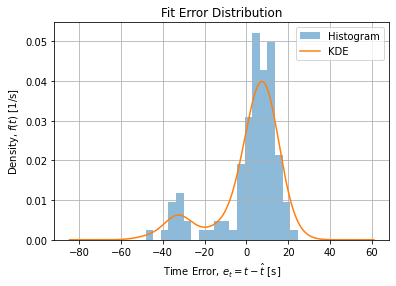

In [23]:
axe = data["err"].plot(kind="hist", bins=20, alpha=0.5, density=1., label="Histogram")
data["err"].plot(kind="kde", ax=axe, label="KDE")
axe.set_title("Fit Error Distribution")
axe.set_xlabel(r"Time Error, $e_t = t - \hat{t}$ [s]")
axe.set_ylabel(r"Density, $f(t)$ [1/s]")
axe.legend()
axe.grid()

## Goodness of Fit

In [24]:
data["chi2"] = data["err"]**2/sigma**2

In [25]:
n = data.shape[0]
chi2 = data["chi2"].sum()
chi2n = chi2 / n
chi2, chi2n

(113.78689215246058, 0.980921484072936)

In [26]:
alpha = 0.01

In [27]:
X = stats.chi2(df=n-1-2)

In [28]:
Xlin = np.linspace(0., max(n*1.5, chi2*1.5), 200)

In [29]:
chi2_c = X.ppf(1-alpha)
chi2_c

150.88215521838262

In [30]:
Xfill = np.linspace(chi2_c, Xlin.max(), 100)

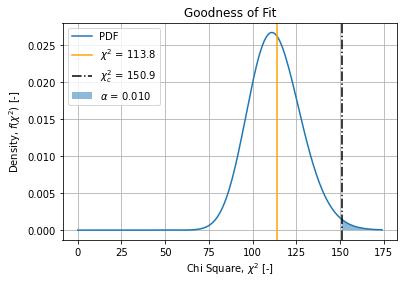

In [31]:
fig, axe = plt.subplots()
axe.plot(Xlin, X.pdf(Xlin), label="PDF")
axe.axvline(chi2, color="orange", label=r"$\chi^2$ = {:.1f}".format(chi2))
axe.axvline(chi2_c, linestyle="-.", color="black", label=r"$\chi^2_c$ = {:.1f}".format(chi2_c))
axe.fill_between(Xfill, X.pdf(Xfill), alpha=0.5, label=r"$\alpha$ = {:.3f}".format(alpha))
axe.set_title("Goodness of Fit")
axe.set_xlabel(r"Chi Square, $\chi^2$ [-]")
axe.set_ylabel(r"Density, $f(\chi^2)$ [-]")
axe.legend()
axe.grid()

## Checks

In [32]:
data["x1"] = data["xi"]/(n0 - data["xi"])
data["x2"] = np.log((n0 - data["xi"])/n0)

### OLS Integrated

In [33]:
def solve_integrated(X, y, name="OLS Integrated"):
    regressor = LinearRegression(fit_intercept=False)
    regressor.fit(X, y)
    R2 = regressor.score(X, y)
    c1, c2 = regressor.coef_
    k1 = n0/((n0*c1 - c2))
    k2 = -c2/(n0*c1 - c2)
    return {"c1": c1, "c2": c2, "k1": k1, "k2": k2, "R2": R2, "name": name, "regressor": regressor}

In [34]:
ols_integrated = solve_integrated(data[["xi", "x2"]].values, data["t"].values)

### Lineweaver-Bürk

In [35]:
def solve_lb(X, y, name):
    regressor = LinearRegression(fit_intercept=True)
    regressor.fit(X, y)
    s = regressor.score(X, y)
    c1 = regressor.intercept_
    c2 = regressor.coef_[0]
    k1 = 1/c1
    k2 = c2/c1
    return {"c1": c1, "c2": c2, "k1": k1, "k2": k2, "R2": s, "name": name, "regressor": regressor}

In [46]:
def plot_solve_lb(X, y, name):
    solution = solve_lb(X, y, name)
    fig, axe = plt.subplots()
    axe.plot(X, y, linestyle="none", marker=".", label="Data")
    axe.plot(X, solution["regressor"].predict(X), label="Fit")
    axe.set_title("Linearization: %s" % name)
    axe.set_xlabel(r"Product/Reactant Ratio, $\frac{\xi}{n_0 - \xi}$ [-]")
    axe.set_ylabel(r"Inverse Kinetic Rate, $\frac{1}{r}$ [s/mol]")
    axe.legend()
    axe.grid()
    return solution, axe

#### First differences

In [47]:
data["r_DxiDt"] = data["xi"].diff()/data["t"].diff()

(50000.0, 400000.0)

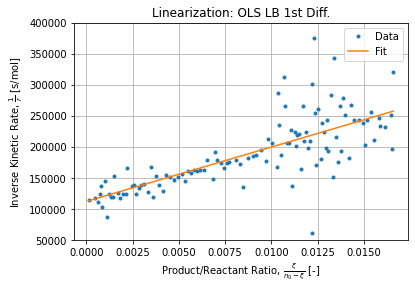

In [56]:
lb_DxiDt, axe = plot_solve_lb(data.loc[1:, ["x1"]].values, 1./data.loc[1:, "r_DxiDt"].values, name="OLS LB 1st Diff.")
axe.set_ylim([50000, 400000])

#### Polynomial estimation

In [39]:
coefs = np.polyfit(data["t"], data["xi"], 3)
data["r_P3"] = np.polyval(np.polyder(coefs, m=1), data["t"])

(50000.0, 400000.0)

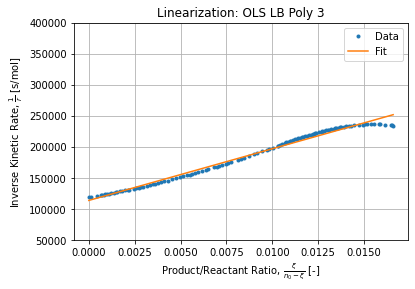

In [55]:
lb_P3, axe = plot_solve_lb(data[["x1"]].values, 1./data["r_P3"].values, name="OLS LB Poly 3")
axe.set_ylim([50000, 400000])

#### Model

In [61]:
def lb(x, k1, k2):
    return k1/(1 + k2*x)

In [62]:
data["r"] = lb(data["x1"], *popt)

In [63]:
data

,t,V,xi,st,that,err,chi2,x1,x2,r_DxiDt,r_P3,r
0,0,0,0,15,-0,0,0,0,0,NaN,8.4226e-06,9.0319e-06
1,39,8.1e-06,0.00033891,15,37.724,1.276,0.0072363,0.00013658,-0.00013657,8.6901e-06,8.3739e-06,8.9366e-06
2,131,2.69e-05,0.0011255,15,126.82,4.1779,0.077576,0.00045374,-0.00045363,8.5501e-06,8.2602e-06,8.7231e-06
3,184,3.83e-05,0.0016025,15,181.9,2.1006,0.019612,0.00064615,-0.00064594,8.9998e-06,8.1954e-06,8.5985e-06
4,214,4.41e-05,0.0018452,15,210.23,3.7746,0.063323,0.00074407,-0.0007438,8.0893e-06,8.1589e-06,8.5364e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
111,6938,0.0009271,0.038791,15,6940.8,-2.8489,0.036072,0.015879,-0.015754,4.2837e-06,4.2387e-06,4.0345e-06
112,7088,0.0009426,0.039439,15,7102.4,-14.351,0.91538,0.016149,-0.01602,4.3236e-06,4.2477e-06,3.9969e-06
113,7272,0.0009601,0.040172,15,7286.5,-14.509,0.93565,0.016453,-0.01632,3.9794e-06,4.2645e-06,3.9553e-06
114,7300,0.0009635,0.040314,15,7322.5,-22.512,2.2524,0.016513,-0.016378,5.0807e-06,4.2676e-06,3.9473e-06


(50000.0, 400000.0)

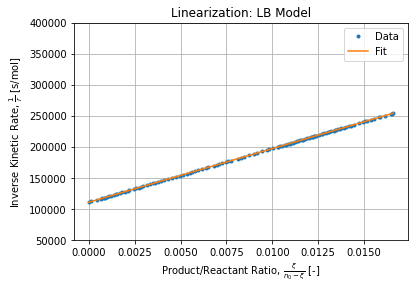

In [65]:
lb_th, axe = plot_solve_lb(data[["x1"]].values, 1./data["r"].values, name="LB Model")
axe.set_ylim([50000, 400000])

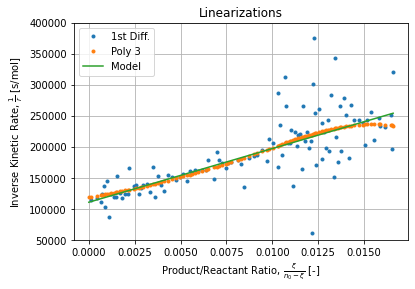

In [68]:
fig, axe = plt.subplots()
axe.plot(data["x1"], 1/data["r_DxiDt"], linestyle="none", marker=".", label="1st Diff.")
axe.plot(data["x1"], 1/data["r_P3"], linestyle="none", marker=".", label="Poly 3")
axe.plot(data["x1"], 1/data["r"], label="Model")
axe.set_title("Linearizations")
axe.set_xlabel(r"Product/Reactant Ratio, $\frac{\xi}{n_0 - \xi}$ [-]")
axe.set_ylabel(r"Inverse Kinetic Rate, $\frac{1}{r}$ [s/mol]")
axe.set_ylim([50000, 400000])
axe.legend()
axe.grid()

In [42]:
pd.set_option('display.float_format', lambda x: '%.5g' % x)

## Summary

In [43]:
results = pd.DataFrame([
    nlls_integrated, ols_integrated,
    lb_DxiDt, lb_P3
])
results

,k1,k2,R2,name,c1,c2,regressor
0,9.0319e-06,78.006,0.99995,NLLS Integrated,NaN,NaN,NaN
1,9.0319e-06,78.006,0.99995,OLS Integrated,-8.526e+06,-2.1434e+07,LinearRegression(fit_intercept=False)
2,8.9335e-06,78.245,0.56512,OLS LB 1st Diff.,1.1194e+05,8.7586e+06,LinearRegression()
3,8.8018e-06,73.221,0.9867,OLS LB Poly 3,1.1361e+05,8.3189e+06,LinearRegression()


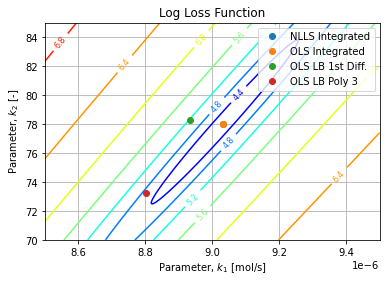

In [44]:
fig, axe = plt.subplots()
contour = axe.contour(K1, K2, MLE, cmap="jet")
axe.clabel(contour, contour.levels, inline=True, fontsize=8)
for index, row in results.iterrows():
    axe.plot([row["k1"]], [row["k2"]], linestyle="none", marker="o", label=row["name"])
axe.set_title("Log Loss Function")
axe.set_xlabel("Parameter, $k_1$ [mol/s]")
axe.set_ylabel("Parameter, $k_2$ [-]")
#axe.set_xscale("log")
#axe.set_yscale("log")
axe.legend()
axe.grid()